# LAB | Audio Classification CNN

## Introduction
This notebook guides you through audio classification using a CNN model on the Kaggle audio dataset. You will:
- Load and explore the dataset
- Apply various preprocessing methods (MFCC, Mel spectrogram, Chromagram)
- Build and train a CNN classifier on these features
- Experiment with preprocessing parameters to improve results

## Step 1: Setup & Dataset Loading

In [1]:
!pip install librosa 


[notice] A new release of pip is available: 24.2 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("warcoder/cats-vs-dogs-vs-birds-audio-classification")

print("Path to dataset files:", path)

100%|██████████| 13.2M/13.2M [00:12<00:00, 1.09MB/s]

Extracting files...


Path to dataset files: C:\Users\Friedrich\.cache\kagglehub\datasets\warcoder\cats-vs-dogs-vs-birds-audio-classification\versions\1


In [4]:
files_in_dir = os.listdir(path)
print(files_in_dir)

['Animals']


In [7]:
#TODO: create a dataframe

data = []
for root, dirs, files in os.walk(path):
    for file in files:
        if file.lower().endswith((".wav", ".mp3", ".flac", ".ogg")):
            filepath = os.path.join(root, file)
            
            # Label assumed to be the parent folder name
            label = os.path.basename(root)
            
            data.append({
                "filename": file,
                "filepath": filepath,
                "label": label
            })

# Create dataframe
df = pd.DataFrame(data)
print(df.head())
df.shape

                filename                                           filepath  \
0  00b01445_nohash_0.wav  C:\Users\Friedrich\.cache\kagglehub\datasets\w...   
1  00f0204f_nohash_1.wav  C:\Users\Friedrich\.cache\kagglehub\datasets\w...   
2  00f0204f_nohash_3.wav  C:\Users\Friedrich\.cache\kagglehub\datasets\w...   
3  01648c51_nohash_0.wav  C:\Users\Friedrich\.cache\kagglehub\datasets\w...   
4  01bcfc0c_nohash_1.wav  C:\Users\Friedrich\.cache\kagglehub\datasets\w...   

  label  
0  bird  
1  bird  
2  bird  
3  bird  
4  bird  


(610, 3)

## Step 2: Audio Preprocessing Functions

Define functions for feature extraction you will experiment with:

- MFCC
- Spectrogram
- Chromogram

In [9]:
##TODO: Your_Code_Here

import librosa
import numpy as np

def extract_mfcc(signal, sample_rate, n_mfcc=13):
    """
    Extract MFCC features from an audio signal.
    
    Parameters:
        signal (np.array): Audio time series
        sample_rate (int): Sampling rate of the audio
        n_mfcc (int): Number of MFCCs to return
    
    Returns:
        np.array: MFCC feature matrix
    """
    mfcc = librosa.feature.mfcc(y=signal, sr=sample_rate, n_mfcc=n_mfcc)
    return mfcc


def extract_spectrogram(signal, sample_rate, n_fft=2048, hop_length=512):
    """
    Extract a magnitude spectrogram from an audio signal.
    
    Parameters:
        signal (np.array): Audio time series
        sample_rate (int): Sampling rate of the audio
        n_fft (int): FFT window size
        hop_length (int): Hop length
    
    Returns:
        np.array: Spectrogram (magnitude)
    """
    stft = librosa.stft(signal, n_fft=n_fft, hop_length=hop_length)
    spectrogram = np.abs(stft)
    return spectrogram


def extract_chromagram(signal, sample_rate, hop_length=512):
    """
    Extract a chromagram from an audio signal.
    
    Parameters:
        signal (np.array): Audio time series
        sample_rate (int): Sampling rate of the audio
        hop_length (int): Hop length
    
    Returns:
        np.array: Chromagram
    """
    chromagram = librosa.feature.chroma_stft(y=signal, sr=sample_rate, hop_length=hop_length)
    return chromagram


## Step 3: Visualize Audio Features

Visualize extracted features for a sample audio file:

Visualizing file: C:\Users\Friedrich\.cache\kagglehub\datasets\warcoder\cats-vs-dogs-vs-birds-audio-classification\versions\1\Animals\bird\00b01445_nohash_0.wav


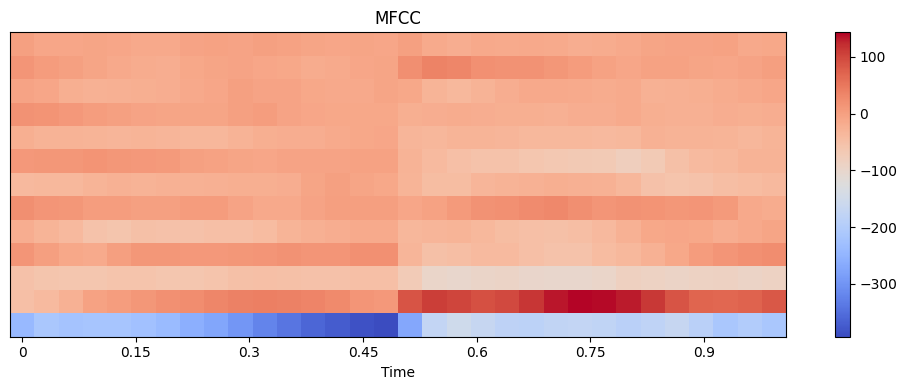

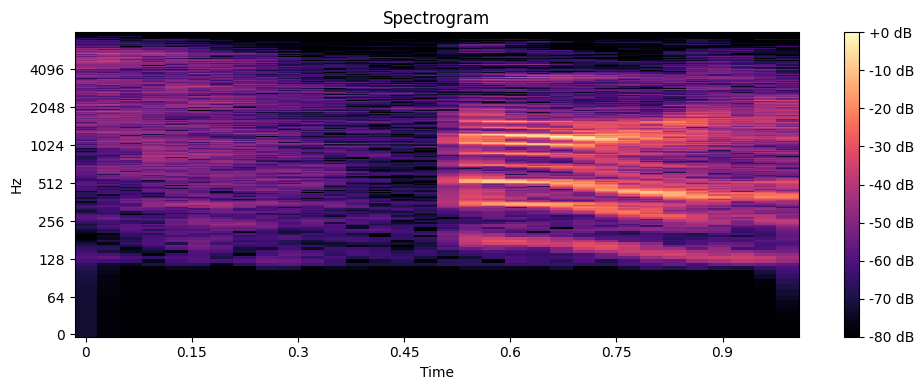

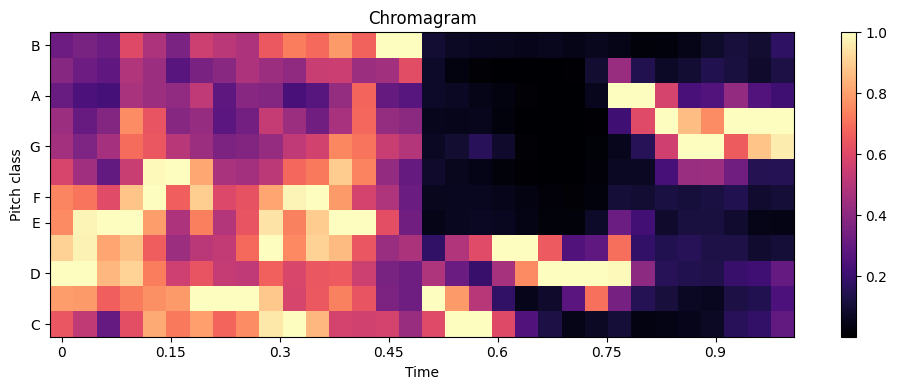

In [10]:
##TODO: Your_Code_Here


import librosa.display
import matplotlib.pyplot as plt

# Select a sample from dataframe
sample_path = df.loc[0, "filepath"]
signal, sr = librosa.load(sample_path, sr=None)

print("Visualizing file:", sample_path)

# Extract features using your functions
mfcc = extract_mfcc(signal, sr)
spectrogram = extract_spectrogram(signal, sr)
chromagram = extract_chromagram(signal, sr)

# ---- MFCC ----
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfcc, x_axis="time", sr=sr)
plt.colorbar()
plt.title("MFCC")
plt.tight_layout()
plt.show()

# ---- Spectrogram ----
spectrogram_db = librosa.amplitude_to_db(spectrogram, ref=np.max)

plt.figure(figsize=(10, 4))
librosa.display.specshow(spectrogram_db, sr=sr, x_axis="time", y_axis="log")
plt.colorbar(format="%+2.0f dB")
plt.title("Spectrogram")
plt.tight_layout()
plt.show()

# ---- Chromagram ----
plt.figure(figsize=(10, 4))
librosa.display.specshow(chromagram, x_axis="time", y_axis="chroma", sr=sr)
plt.colorbar()
plt.title("Chromagram")
plt.tight_layout()
plt.show()



## Step 4: Prepare Data for CNN

Extract features for all files and prepare train/test sets:

In [13]:
##TODO: Your_Code_Here

import librosa
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

max_len = 130   # number of time frames to keep

features = []
labels = []

for index, row in df.iterrows():
    try:
        signal, sr = librosa.load(row["filepath"], sr=None)

        mfcc = extract_mfcc(signal, sr)

        # Pad or truncate to fixed length
        if mfcc.shape[1] < max_len:
            pad_width = max_len - mfcc.shape[1]
            mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
        else:
            mfcc = mfcc[:, :max_len]

        features.append(mfcc)
        labels.append(row["label"])

    except Exception as e:
        print("Error processing:", row["filepath"], e)

# Convert to numpy arrays
X = np.array(features)
y = np.array(labels)

print("Feature shape:", X.shape)
print("Labels shape:", y.shape)

# Encode labels to numeric
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)
print("Classes:", encoder.classes_)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Add channel dimension for CNN
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


Feature shape: (610, 13, 130)
Labels shape: (610,)
Classes: ['bird' 'cat' 'dog']
X_train shape: (488, 13, 130, 1)
X_test shape: (122, 13, 130, 1)
y_train shape: (488,)
y_test shape: (122,)


## Step 5: Define CNN Model

In [14]:
##TODO: Your_Code_Here

input_shape = X_train.shape[1:]  # (height, width, channels)

model = Sequential([
    
    Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    MaxPooling2D((2,2)),
    
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    
    Flatten(),
    
    Dense(128, activation='relu'),
    Dropout(0.3),
    
    Dense(len(set(y_train)), activation='softmax')  # number of classes
])


c:\Users\Friedrich\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [15]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 11, 128, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 5, 64, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 3, 62, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 1, 31, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1984)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       254,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 273,283 (1.04 MB)

 Trainable params: 273,283 (1.04 MB)

 Non-trainable params: 0 (0.00 B)

## Step 6: Train and Evaluate

In [18]:
##TODO: Your_Code_Here

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=15,
    batch_size=32
)


Epoch 1/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9561 - loss: 0.1275 - val_accuracy: 0.8934 - val_loss: 0.4507
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9858 - loss: 0.0716 - val_accuracy: 0.9016 - val_loss: 0.4615
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9755 - loss: 0.0630 - val_accuracy: 0.9180 - val_loss: 0.4599
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9895 - loss: 0.0490 - val_accuracy: 0.9016 - val_loss: 0.4322
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9948 - loss: 0.0353 - val_accuracy: 0.9180 - val_loss: 0.4009
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9988 - loss: 0.0172 - val_accuracy: 0.8852 - val_loss: 0.4536
Epoch 7/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9962 - loss: 0.0248 - val_accuracy: 0.8934 - val_loss: 0.5293
Epoch 8/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9868 - loss: 0.0380 - val_accuracy: 0.9016 - val_loss

In [19]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test accuracy:", test_acc)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8921 - loss: 0.5416 
Test accuracy: 0.9098360538482666


## Step 7: Experimentation

- Try using Mel Spectrogram and Chromagram as features instead of MFCC by changing the `feature_extractor` function in the data preparation.
- Modify parameters like `n_mfcc`, `n_mels`, `max_len`.
- Tune CNN architecture (add layers, change filters).
- Compare results and report observations.
